In [132]:
%pip install -q -r requirements.txt

Note: you may need to restart the kernel to use updated packages.


In [133]:
import torch
import os
from torchvision import transforms
import torch.nn as nn
import pandas as pd
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from torchvision.datasets import CelebA
import cv2

# Set up the device
if torch.backends.mps.is_available():
    device = torch.device("mps")
else:
    device = torch.device("cpu")
print("Using device:", device)

Using device: mps


In [134]:
class CropFaceUsingLandmarks(object):
    def __init__(self, horizontal_margin=0.1, top_margin=0.0, bottom_margin=0.1):
        """
        Args:
            horizontal_margin (float): Fractional margin to add on the left/right sides.
            top_margin (float): Fractional margin to include above the eye line
                (relative to the distance between eyes and mouth). A positive value
                means include additional area above the eyes.
            bottom_margin (float): Fractional margin to add below the mouth
                (relative to the distance between eyes and mouth).
        """
        self.horizontal_margin = horizontal_margin
        self.top_margin = top_margin
        self.bottom_margin = bottom_margin

    def __call__(self, sample):
        """
        Args:
            sample (dict): Contains 'image' (PIL Image) and 'landmarks'.
                           Landmarks can be provided as a flat array (length 10) or an array of shape (5,2).
                           Landmark order: [left_eye, right_eye, nose, left_mouth, right_mouth].
        Returns:
            sample (dict): Updated sample with 'image' cropped to the region between eyes and mouth,
                           and adjusted 'landmarks'.
        """
        img, landmarks = sample['image'], sample['landmarks']
        # Convert landmarks to a NumPy array.
        landmarks = np.array(landmarks)
        
        # Reshape if landmarks are provided as a flat array.
        if landmarks.ndim == 1 and landmarks.shape[0] == 10:
            landmarks = landmarks.reshape(-1, 2)
        
        # Extract the relevant landmarks:
        # Eyes at indices 0 and 1, mouth corners at indices 3 and 4.
        left_eye = landmarks[0]
        right_eye = landmarks[1]
        left_mouth = landmarks[3]
        right_mouth = landmarks[4]
        
        # Determine vertical boundaries:
        # Eye line: use the lower of the two eyes.
        eye_y = max(left_eye[1], right_eye[1])
        # Mouth line: use the higher of the two mouth corners.
        mouth_y = min(left_mouth[1], right_mouth[1])
        # The distance between eyes and mouth (used for margin scaling)
        d = mouth_y - eye_y
        
        # Set the top and bottom with margins
        top = int(eye_y - self.top_margin * d)
        bottom = int(mouth_y + self.bottom_margin * d)
        
        # Determine horizontal boundaries:
        left_x = min(left_eye[0], right_eye[0], left_mouth[0], right_mouth[0])
        right_x = max(left_eye[0], right_eye[0], left_mouth[0], right_mouth[0])
        region_width = right_x - left_x
        left_expanded = int(max(0, left_x - self.horizontal_margin * region_width))
        right_expanded = int(right_x + self.horizontal_margin * region_width)
        
        # Define the bounding box: (left, top, right, bottom)
        bbox = (left_expanded, top, right_expanded, bottom)
        
        # Crop the image.
        cropped_img = img.crop(bbox)
        
        # Adjust landmarks to the new coordinate system of the cropped image.
        landmarks_transformed = landmarks - np.array([left_expanded, top])
        landmarks_transformed = landmarks_transformed.flatten()  # Flatten if needed.
        
        # Update and return the sample.
        sample['image'] = cropped_img
        sample['landmarks'] = landmarks_transformed
        return sample


class CelebADatasetWithLandmarks(CelebA):
    def __init__(self, root, split, target_type, transform=None, download=False):
        # Disable the default transform so that we get the raw image
        super().__init__(root=root, split=split, target_type=target_type, transform=None, download=download)
        self.custom_transform = transform

    def __getitem__(self, index):
        # The parent returns a tuple of (image, target).
        # When target_type is ['landmarks'], target is the landmarks.
        img, target = super().__getitem__(index)
        sample = {'image': img, 'landmarks': target}

        if self.custom_transform is not None:
            sample = self.custom_transform(sample)

        return sample
    
    
class DictCompose(object):
    """Compose transformations that operate on dict samples."""
    def __init__(self, transforms):
        self.transforms = transforms

    def __call__(self, sample):
        for t in self.transforms:
            sample = t(sample)
        return sample
    

class LightNormalizationCLAHE(object):
    def __init__(self, clipLimit=2.0, tileGridSize=(8, 8)):
        """
        Args:
            clipLimit (float): Threshold for contrast limiting.
            tileGridSize (tuple): Size of grid for histogram equalization.
        """
        self.clipLimit = clipLimit
        self.tileGridSize = tileGridSize

    def __call__(self, image):
        """
        Args:
            image (PIL Image): The input image.
        Returns:
            image (PIL Image): The lighting-normalized image.
        """
        # Convert PIL image to numpy array (RGB order)
        img = np.array(image)
        
        # Convert from RGB to LAB color space
        lab = cv2.cvtColor(img, cv2.COLOR_RGB2LAB)
        
        # Split into individual channels
        l_channel, a_channel, b_channel = cv2.split(lab)
        
        # Create a CLAHE object (Contrast Limited Adaptive Histogram Equalization)
        clahe = cv2.createCLAHE(clipLimit=self.clipLimit, tileGridSize=self.tileGridSize)
        
        # Apply CLAHE to the L (lightness) channel
        cl = clahe.apply(l_channel)
        
        # Merge the CLAHE enhanced L-channel back with a and b channels
        lab_clahe = cv2.merge((cl, a_channel, b_channel))
        
        # Convert back from LAB to RGB color space
        normalized_img = cv2.cvtColor(lab_clahe, cv2.COLOR_LAB2RGB)
        
        # Convert NumPy array back to PIL Image and return
        return Image.fromarray(normalized_img)

In [154]:
transform = DictCompose([
    CropFaceUsingLandmarks(horizontal_margin=0.3, top_margin=-0.2, bottom_margin=-0.1),
    # Resize the cropped face to 224x224
    lambda sample: {'image': transforms.Resize((224, 224))(sample['image']),
                    'landmarks': sample['landmarks']},
    # Apply CLAHE for lighting normalization
    lambda sample: {'image': LightNormalizationCLAHE(clipLimit=2.0, tileGridSize=(4, 4))(sample['image']),
                    'landmarks': sample['landmarks']},
    # Convert image to a tensor
    lambda sample: {'image': transforms.ToTensor()(sample['image']),
                    'landmarks': sample['landmarks']},
    # # Normalize the tensor image
    # lambda sample: {'image': transforms.Normalize(mean=[0.5, 0.5, 0.5], 
    #                                                std=[0.5, 0.5, 0.5])(sample['image']),
    #                 'landmarks': sample['landmarks']}
])

# define the data directory
data_dir = "/Users/sree"

celeba = CelebADatasetWithLandmarks(
    root=data_dir,
    split='train',
    target_type=['landmarks'],
    transform=transform,
    download=True
)

Files already downloaded and verified


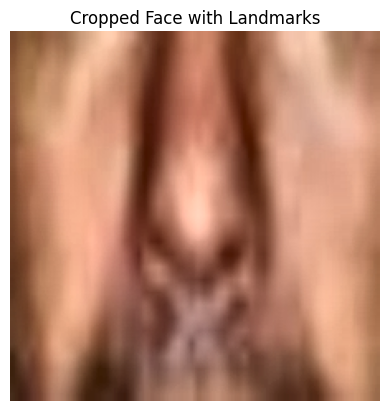

In [155]:
sample = celeba[3666]

# plot the tensor
plt.imshow(sample['image'].permute(1, 2, 0).numpy())
plt.title('Cropped Face with Landmarks')
plt.axis('off')
plt.show()